Self corrective RAG with LangGraph

In [1]:
from dotenv import load_dotenv, find_dotenv
import os
load_dotenv(find_dotenv())

True

**Create Vector DB**
- Create a chroma db vector store using some sample documents about a restaurant. 

In [ ]:
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma

embeddings = OpenAIEmbeddings()
docs = [
    Document(
        page_content = "Gourmet Haven is owned by celebrated chef and entrepreneur Lisa Martinez, is a popular dining spot known for its blend of tradition and innovation.",
        metadata={"source":"restaurant.txt"}
    ),
    Document(
        page_content = "Situated in the heart of downtown San Francisco, Gourmet Haven welcomes diners from 11:00 AM to 10:00 PM on weekdays and extends its hours until midnight on weekends.",
        metadata={"source":"restaurant.txt"}
    ),
    Document(
        page_content = "The menu at Gourmet Haven boasts a diverse selection, from freshly prepared seafood and prime steak cuts to plant-based dishes and artisanal pastas, ensuring options for every palate.",
        metadata={"source":"restaurant.txt"}
    ),
     Document(
        page_content = " The restaurant\'s signature dish, Truffle Infused Lobster Risotto, paired with a curated wine selection, is highly recommended for those looking for an exquisite dining experience.",
        metadata={"source":"restaurant.txt"}
    ),
     Document(
        page_content = "Known for its cozy, upscale ambiance and attentive service, Gourmet Haven offers a perfect blend of comfort and luxury, making it ideal for romantic dinners or special celebrations.",
        metadata={"source":"restaurant.txt"}
    )
]
vectorstore = Chroma.from_documents(docs, embeddings)
retriever = vectorstore.as_retriever()

**Create AgentState for storing state in LangGraph**

![alt text](image.png)

In [7]:
from typing_extensions import TypedDict

class AgentState(TypedDict):
    question:str
    grades:list[str]
    llm_output:str
    documents:list[str]
    on_topic:bool

In [24]:
# Now define the methods for each nodes

# Step 1: Retrieve documents related to user query
def retrieve_docs(state: AgentState):
    """
    Retrieve documents related to the user query.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state with retrieved documents.
    """
    # get the question from the state
    question = state["question"]
    # get the documents related to the question
    docs = retriever.get_relevant_documents(query=question)
    for doc in docs:
        print(doc)
       
    # update the state with the retrieved documents
    state["documents"] = docs
    # return the updated state
    return state


In [9]:
# Step 2: Grade the question if it is relevant to RAG
# use llm structured output to get the output in a format
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

class GradeQuestion(BaseModel):
    """Binary score if the question is relevant to Gourmet Haven"""

    score: str = Field(description="question is about resturant? If yes -> 'Yes'if not->'No'")

def question_classifier(state: AgentState):
    question = state["question"]

    system = """ You are a grader assessing the relevance of a retrieved document to a user question.\n
            Only answer if the question is about one of the following topics:
            1. Information about the owner of Gourmet Haven
            2. Prices of the dishes at Gourmet Haven
            3. Opeation hours of Gourmet Haven
            4. Special at Gourmet Haven
            
            If the question is about these topics reply with 'Yes', else response with 'No' """
    grade_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "User Question: {question}"),
        ]
    )
    llm= ChatOpenAI()
    structed_llm = llm.with_structured_output(GradeQuestion)
    chain = grade_prompt | structed_llm
    result= chain.invoke({"question": question})
    state["on_topic"] = result.score
    return state

In [10]:
# Step 3: Check the State on_topic. If it is yes return on_topic else return off_topic. This will help us to route
def on_topic_router(state:AgentState):
    on_topic = state["on_topic"]
    if on_topic.lower() == "yes":
        return "on_topic"
    return "off_topic"

In [12]:
# Step 4: If it is Off-topic, then send the off-topic response. Here we can set the response without using the LLM.

def off_topic_response(state: AgentState):
    print("Off-topic response")
    state["llm_output"] = "Sorry!. I can't respond on this topic question"
    return state

In [13]:
# Step 5: Perform the grading on the retrieved documents. For each document check with a llm whether 
# the docs is relevant. If so mark the document as yes other wise no. 
# Here also we can use structred output

class gradeDocument(BaseModel):
    """ Boolean values to check for relevance on retrieved documents"""
    score: str = Field(description="Documents are relevant to the question 'Yes' or 'No'")

def document_grader(state: AgentState):
    """
    Determine whether the retrieved documents are relevant to the question.
    """
    # get the docs and question
    docs = state["documents"]
    question = state["question"]
    # check the docs for relevance using llm

    system = """You are a world class algorithm to determine whether or not the documents retrieved are relevant to the question. 
    If the documents contains keyword(s) or semantic meaning related to the question, then grade it as relevant.\n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
    
    # prompt template
    grade_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", " Retrieved Document: {document}\n User Question: {question}"),
        ]
    )   

    llm = ChatOpenAI()
    structured_llm = llm.with_structured_output(gradeDocument)
    chain = grade_prompt | structured_llm
    scores =[]
    for doc in docs:
        result = chain.invoke({"document":doc,"question":question})
        scores.append(result.score)
    state["grades"] = scores
    return state

In [14]:
# Based on the Grade, decide on whether to generate answer or do a rewrite query and query docs again
def gen_router(state: AgentState):
    grades = state["grades"]
    print("Document Grades:",grades)

    if any(grade.lower() == "yes" for grade in grades):
        print("Getting documents with Grade as Yes")
        filtered_grades = [grade for grade in grades if grade.lower() == "yes"]
        print("Filtered Grades:", filtered_grades)
        return "generate"
    else:
        print("Getting documents with Grade as No")
        filtered_grades = [grade for grade in grades if grade.lower() == "no"]
        print("Filtered Grades:", filtered_grades)
        return "rewrite_query"

In [15]:
# Now the Re-Writter
from langchain_core.output_parsers import StrOutputParser

def rewriter(state: AgentState):
    # get the question
    question = state["question"]
    system = """You a question re-writer that converts an input question to a better version that is optimized for\
                retrieval. Look at the input and try to reason about the underlying semantic intent /meaning."""
    re_writer_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "Here is the initial question:\n\n {question} \n Formulate an improved question."),
        ]
    )
    llm = ChatOpenAI()
    question_rewriter_chain = re_writer_prompt | llm | StrOutputParser()
    result = question_rewriter_chain.invoke({"question": question})
    # set the new question
    state["question"] = result
    return state


In [21]:
# Everything is good, so we can generate the answer with the retrieved docs
from langchain_core.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser
def generate_answer(state: AgentState):
    # get the question from state
    question = state["question"]
    # get the retrieved docs from state
    context = state["documents"]

    template = """ Answer the question based only on the following context
    Question: {question} 
    \n
    Context: {context}
    """
    prompt = ChatPromptTemplate.from_template(template)
    llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
    chain = prompt | llm | StrOutputParser()
    answer = chain.invoke({"question": question, "context": context})
    # set the state's llm output 
    state["llm_output"] = answer
    # return back the updated state
    return state

**Now Define the Workflow**

In [25]:
from langgraph.graph import StateGraph, END
# define the langgraph workflow
workflow = StateGraph(AgentState)

# define the nodes
# define a name to the node and set the corrsponding function to be called.
workflow.add_node("topic_decision",question_classifier)
workflow.add_node("off_topic_response",off_topic_response)
workflow.add_node("retrieve_docs",retrieve_docs)
workflow.add_node("document_grader", document_grader)
workflow.add_node("rewrite_query", rewriter)
workflow.add_node("generate_answer", generate_answer)

# define the edges that connects the above nodes
workflow.add_conditional_edges( 
 "topic_decision",
   on_topic_router,
    {

        "off_topic": "off_topic_response",
        "on_topic": "retrieve_docs"
    }
)
workflow.add_edge("retrieve_docs", "document_grader")
workflow.add_edge("off_topic_response",END)
workflow.add_conditional_edges("document_grader",
    gen_router,
    {

        "generate": "generate_answer",
        "rewrite_query": "rewrite_query"
    }
)
workflow.add_edge("rewrite_query", "retrieve_docs")
workflow.add_edge("generate_answer", END)

# set the entry point
workflow.set_entry_point("topic_decision")
# compile the workflow
app = workflow.compile()


**Visualize the graph**

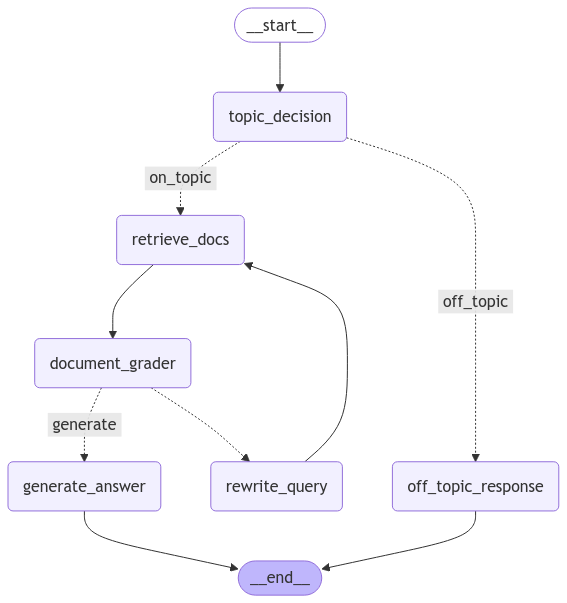

In [18]:
from IPython.display import display, Image 
try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    print("No graph found")

In [19]:
# Execute the Workflow
result = app.invoke({"question":"How is the weather?"})
result["llm_output"]

Off-topic response


"Sorry!. I can't respond on this topic question"

In [26]:
result = app.invoke({"question":"what is the hours of operation of Gourmet Haven?"})
result["llm_output"]

page_content='Situated in the heart of downtown San Francisco, Gourmet Haven welcomes diners from 11:00 AM to 10:00 PM on weekdays and extends its hours until midnight on weekends.' metadata={'source': 'restaurant.txt'}
page_content='The menu at Gourmet Haven boasts a diverse selection, from freshly prepared seafood and prime steak cuts to plant-based dishes and artisanal pastas, ensuring options for every palate.' metadata={'source': 'restaurant.txt'}
page_content='Known for its cozy, upscale ambiance and attentive service, Gourmet Haven offers a perfect blend of comfort and luxury, making it ideal for romantic dinners or special celebrations.' metadata={'source': 'restaurant.txt'}
page_content='Gourmet Haven is owned by celebrated chef and entrepreneur Lisa Martinez, is a popular dining spot known for its blend of tradition and innovation.' metadata={'source': 'restaurant.txt'}
Document Grades: ['yes', 'no', 'no', 'no']
Getting documents with Grade as Yes
Filtered Grades: ['yes']


'Gourmet Haven is open from 11:00 AM to 10:00 PM on weekdays and extends its hours until midnight on weekends.'